In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [252]:
# File with public supply total GW + SW
usgs_2020 = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\PS_HUC12_GW_2000_2020.csv')
# Machine learning model output for domestic demand per capita
dpc_2020 = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\delivery_water_use_model\predictions\national_dpc_predictions.csv')
# Baseline water treatment train files
wt_baseline = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_wt_baseline_spreadsheet.csv')
# Read state and county shapefiles
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')
us_states = us_states.to_crs("EPSG:4326")
# USGS 2017 data for WSA
usgs_wsa = gp.read_file(r'C:\Users\mhardika\Downloads\WSA_v1\WSA_v1\WSA_v1.shp')
usgs_gu_wwsa = gp.read_file(r'C:\Users\mhardika\Downloads\V1_GU_wWS\V1_GU_wWS\v1_GU_wWS.shp')
# Population data set
pop_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')
pop_df = pop_df[~(pop_df == 0).any(axis=1)].reset_index(drop=True)

state_geocode = pd.read_csv(r'C:\Users\mhardika\Documents\watertap3\WaterTAP3\watertap3\watertap3\data\state_geocode.csv')

USGS Data Analysis Datasets:
1. 2000-2020 HUC dataset
2. National DPC modeled using the 2000-2020 dataset
3. WSA dataset with poylgons describing service area and population in each service area. (what year?)
4. A more details geographical unit (GU) data set

In [191]:
# pop_df.head(2)

,state_id,county_id,geoid,county,ssp22020,ssp22050,ssp32050,ssp52050
0,2,13,2013,Aleutians East,3765.43874,6050.720238,5182.924996,6957.02629
1,2,16,2016,Aleutians West,6434.11080,11483.808730,9660.874462,13429.41854


In [207]:
usgs_wsa_sorted = usgs_wsa.sort_values('WSA_AGIDF')
# usgs_wsa_sorted.head(2)
usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='WA5324164']

,WSA_AGIDF,POLY_COUNT,WSA_SQKM,TPOLYPOP,TPOPSRV,STATE_NAME,WSA_NAME,geometry
17395,WA5324164,1,0.025163,39,39,Washington,EVERGREEN RETREAT MHP,"POLYGON Z ((-1942274.881 3128880.074 0.000, -1..."


In [240]:
# wt_baseline[wt_baseline['State Code']=='CA']

In [141]:
usgs_wsa_sorted['WSA_AGIDF'][0]
# wt_baseline['PWS ID'][0]

# usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='042800002']['TPOPSRV'].values[0]
wt_baseline[wt_baseline['PWS ID']=='042800002']['Population Served Count'].values[0]

820

In [257]:
# For the state of New York filter list facilities from both SDWIS and USGS (DPC) and list where they list
# Comparison of USGS and SDWIS data of population

combined_df = pd.DataFrame()
# Grab PWS ID and WSA from SDWIS and USGS data
pws_id = wt_baseline['PWS ID'].values
wsa = usgs_wsa_sorted['WSA_AGIDF'].values

all_wsa_pwd = np.concatenate([wsa,pws_id])
combined_df['combined_ids'] = all_wsa_pwd
combined_df.drop_duplicates('combined_ids',inplace=True)
combined_df.dropna(inplace=True)

combined_df.reset_index(inplace=True)
combined_df.drop(columns='index',inplace=True)
print('SDWIS data:',len(pws_id))
print('USGS data:',len(wsa))
print('Combined:',len(combined_df['combined_ids']))

usgs_pop_list = []
sdwis_pop_list = []
state_code_list = []
usgs_check_list = []
sdwis_check_list = []

for idx,row in combined_df.iterrows():
    state = []
    if row['combined_ids'] in wt_baseline['PWS ID'].values:
        sdwis_check_list.append(1)
        sdwis_pop_list.append(wt_baseline[wt_baseline['PWS ID']==row['combined_ids']]['Population Served Count'].values[0])
        state = wt_baseline[wt_baseline['PWS ID']==row['combined_ids']]['State Code'].values[0]
        
    else:
        sdwis_check_list.append(0)
        sdwis_pop_list.append(0)
        state_name = usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0]
        state = state_geocode[state_geocode['state']==state_name]['abbv'].values[0]
        # state_code_list.append()

    if row['combined_ids'] in usgs_wsa_sorted['WSA_AGIDF'].values:
        usgs_check_list.append(1)
        usgs_pop_list.append(usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['TPOPSRV'].values[0])
        state_name= usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0]
        state = state_geocode[state_geocode['state']==state_name]['abbv'].values[0]
        # state_code_list.append(usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']==row['combined_ids']]['STATE_NAME'].values[0])
    else:
        usgs_check_list.append(0)
        usgs_pop_list.append(0)
    state_code_list.append(state)

combined_df['usgs_check'] = usgs_check_list
combined_df['sdwis_check'] = sdwis_check_list
combined_df['usgs_pop'] = usgs_pop_list
combined_df['sdwis_pop'] = sdwis_pop_list
combined_df['state_code'] = state_code_list

# combined_df.reset_index(inplace=True)

combined_df


SDWIS data: 36020
USGS data: 18806
Combined: 38319


,combined_ids,usgs_check,sdwis_check,usgs_pop,sdwis_pop,state_code
0,010106001,1,1,48836,37807,CT
1,042800001,1,1,1072,1072,MS
2,042800002,1,1,820,820,MS
3,042800003,1,1,3164,3164,MS
4,042800004,1,1,920,920,MS
...,...,...,...,...,...,...
38314,WY5680001,0,1,0,470,WY
38315,WY5680085,0,1,0,6225,WY
38316,WY5680093,0,1,0,177,WY
38317,WY5680095,0,1,0,4459,WY


In [225]:
# combined_df.head()

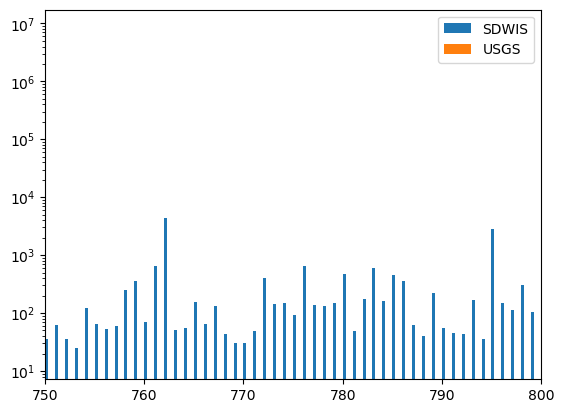

In [293]:
# Checking population for New York
state_code = 'NY'
combined_df_state = combined_df.loc[(combined_df['state_code']==state_code) ]
# combined_df_ny['sdwis_pop'].values
fig, ax = plt.subplots()
x = np.arange(0,len(combined_df_state))
# print(x,len(combined_df_ny))
ax.bar(x+0.15, combined_df_state['sdwis_pop'],width=0.3,label='SDWIS')
ax.bar(x-0.15, combined_df_state['usgs_pop'],width=0.3,label='USGS')
ax.set_yscale('log')
ax.set_xlim([750,800])
ax.legend()


In [294]:
print('SDWIS',combined_df_state['sdwis_pop'].sum())
print('USGS',combined_df_state['usgs_pop'].sum())

state_id = state_geocode[state_geocode['abbv']==state_code]['state_id'].values[0]
print(state_id)
pop_df_state = pop_df.loc[pop_df['state_id']==state_id].copy()
print('Hauer population data',round(pop_df_state['ssp22020'].sum()))

SDWIS 16982356
USGS 19069247
36
Hauer population data 20242666


In [295]:
# Count number of facilities only in SDWIS
print('Facilities in SDWIS not in USGS', len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==0)]))
print('Facilities in USGS not in SDWIS', len(combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]))

# Count number of facilities where population is very different

Facilities in SDWIS not in USGS 1284
Facilities in USGS not in SDWIS 28


In [297]:
usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='NY0200315']

,WSA_AGIDF,POLY_COUNT,WSA_SQKM,TPOLYPOP,TPOPSRV,STATE_NAME,WSA_NAME,geometry
10682,NY0200315,1,2.06353,1047,1040,New York,BOLIVAR VILLAGE PUBLIC WATER,"POLYGON Z ((1456912.538 2257026.296 0.000, 145..."


In [296]:
combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]

,combined_ids,usgs_check,sdwis_check,usgs_pop,sdwis_pop,state_code
141,430516073353600,1,0,605,0,NY
143,936000000355,1,0,18871,0,NY
10682,NY0200315,1,0,1040,0,NY
10687,NY0200324,1,0,600,0,NY
10702,NY0400338,1,0,520,0,NY
10710,NY0400352,1,0,870,0,NY
10715,NY0501716,1,0,600,0,NY
10720,NY0600353,1,0,5185,0,NY
10748,NY0900213,1,0,1228,0,NY
10789,NY1302774,1,0,85000,0,NY


In [268]:
id = 'PA1150083'
print(combined_df_state[combined_df_state['combined_ids']==id])
print(combined_df[combined_df['combined_ids']==id])

# print(usgs_wsa_sorted[usgs_wsa_sorted['WSA_AGIDF']=='WI4430494'])

wt_baseline[wt_baseline['PWS ID']==id]

      combined_ids  usgs_check  sdwis_check  usgs_pop  sdwis_pop state_code
33062    PA1150083           0            1         0        200         NY
      combined_ids  usgs_check  sdwis_check  usgs_pop  sdwis_pop state_code
33062    PA1150083           0            1         0        200         NY


,PWS ID,PWS Name,Population Served Count,Activity Status,Primary Source,PWS Type,City Name,State Code,Zip Code,Latitude,...,"Ozonation, Post","Ozonation, Pre",Permanganate,Peroxide,Rapid Mix,Reverse Osmosis,Sedimentation,Sequestration,Sludge Treatment,Ultraviolet Radiation
25035,PA1150083,CREEKVIEW MHP,200,Active,Ground water,Community water system,NEW YORK,NY,10022,NaN,...,0,0,0,0,0,0,0,0,0,0


In [289]:
# Going through all states and checking things

combined_state_wise_df = pd.DataFrame()

state_code_list = []
usgs_state_pop_list = []
sdwis_state_pop_list = []
hauer_state_pop_list = []
sdwis_only_list = []
usgs_only_list = []
common_facilities_list = []
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','DE','FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC')


for state in contiguous_usa:
    state_code_list.append(state)
    combined_df_state = combined_df.loc[(combined_df['state_code']==state)]
    usgs_state_pop_list.append(combined_df_state['usgs_pop'].sum())
    sdwis_state_pop_list.append(combined_df_state['sdwis_pop'].sum())
    
    state_id = state_geocode[state_geocode['abbv']==state]['state_id'].values[0]
    pop_df_state = pop_df.loc[pop_df['state_id']==state_id].copy()
    hauer_state_pop_list.append(pop_df_state['ssp22020'].sum())
    sdwis_only_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==0)]))
    usgs_only_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==0) & (combined_df_state['usgs_check']==1)]))
    common_facilities_list.append(len(combined_df_state[(combined_df_state['sdwis_check']==1) & (combined_df_state['usgs_check']==1)]))
    
combined_state_wise_df['state_code'] = state_code_list
combined_state_wise_df['usgs_state_pop'] = usgs_state_pop_list
combined_state_wise_df['sdwis_state_pop'] = sdwis_state_pop_list
combined_state_wise_df['hauer_state_pop'] = hauer_state_pop_list
combined_state_wise_df['sdwis_only'] = sdwis_only_list
combined_state_wise_df['usgs_only'] = usgs_only_list
combined_state_wise_df['common_facilities'] = common_facilities_list

combined_state_wise_df.head(2)


,state_code,usgs_state_pop,sdwis_state_pop,hauer_state_pop,sdwis_only,usgs_only,common_facilities
0,AL,4779389,5312925,4.959771e+06,127,14,273
1,AZ,5903021,6758121,7.300009e+06,419,99,286


In [291]:
len(combined_df.loc[(combined_df['state_code']=='AL')])
14+127+273

414

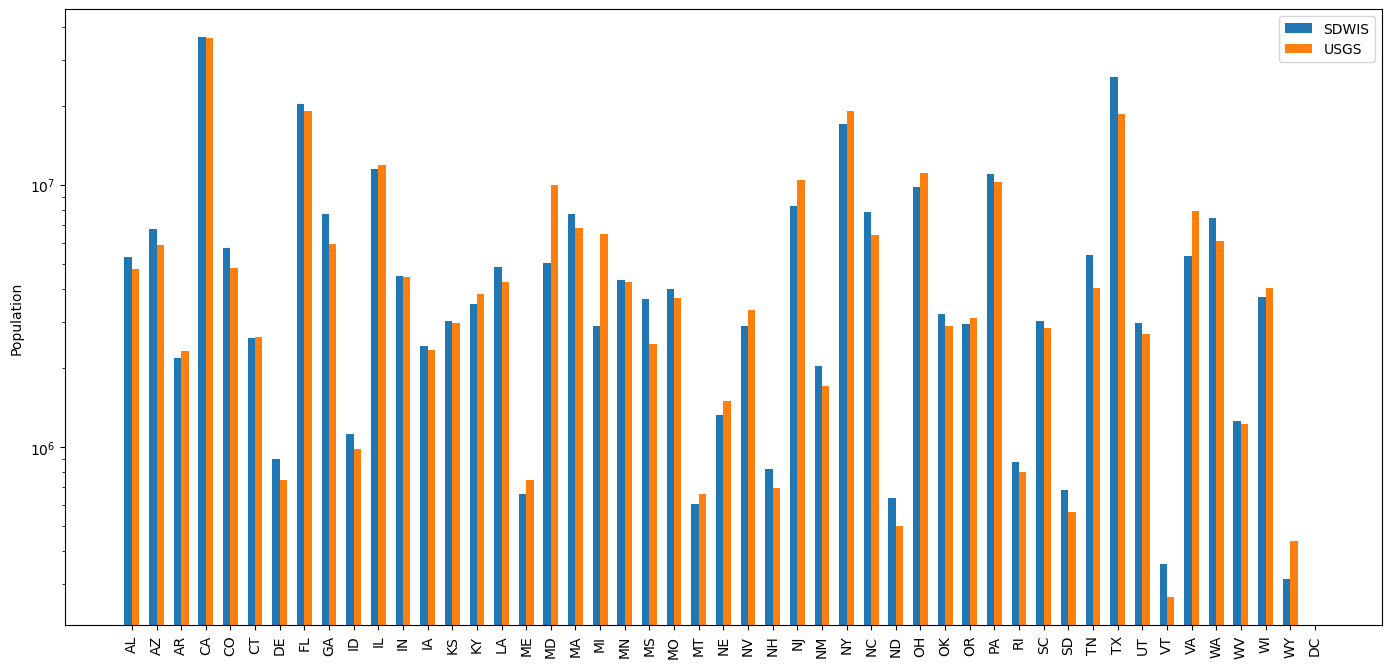

In [279]:
fig, ax = plt.subplots(figsize=(17,8))
x = np.arange(0,len(combined_state_wise_df))
# print(x,len(combined_df_ny))
ax.bar(x-0.15, combined_state_wise_df['sdwis_state_pop'],width=0.3,label='SDWIS')
ax.bar(x+0.15, combined_state_wise_df['usgs_state_pop'],width=0.3,label='USGS')
ax.set_yscale('log')
ax.set_xticks(range(0,len(contiguous_usa)),contiguous_usa,rotation = 90)
# ax.set_xlim([750,800])
ax.set_ylabel('Population')
ax.legend()

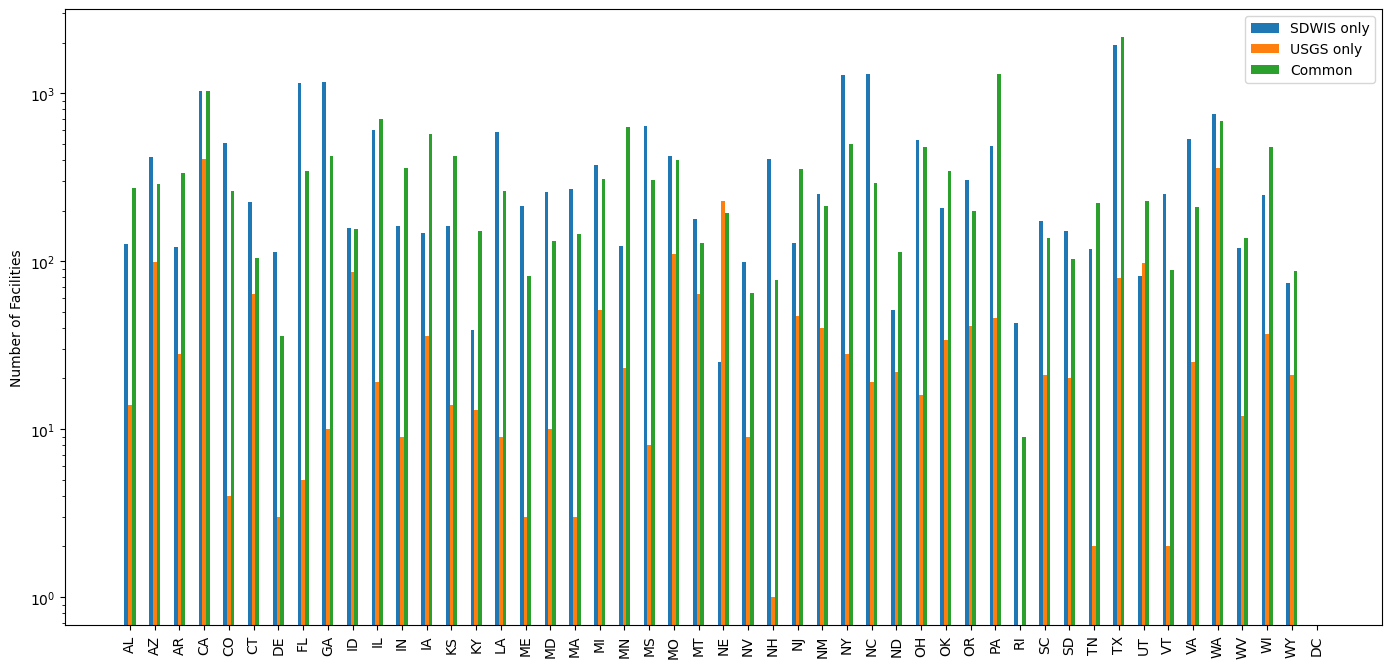

In [285]:
fig, ax = plt.subplots(figsize=(17,8))
x = np.arange(0,len(combined_state_wise_df))
# print(x,len(combined_df_ny))
ax.bar(x-0.15, combined_state_wise_df['sdwis_only'],width=0.15,label='SDWIS only')
ax.bar(x, combined_state_wise_df['usgs_only'],width=0.15,label='USGS only')
ax.bar(x+0.15, combined_state_wise_df['common_facilities'],width=0.15,label='Common')
ax.set_yscale('log')
ax.set_xticks(range(0,len(contiguous_usa)),contiguous_usa,rotation = 90)
# ax.set_xlim([750,800])
ax.set_ylabel('Number of Facilities')
ax.legend()

In [78]:
# usgs_gu_wwsa_state = usgs_gu_wwsa.loc[usgs_gu_wwsa['STATE_NAME']=='New York']

# geodf_gu_wwsa = gp.GeoDataFrame(usgs_gu_wwsa_state, geometry=usgs_gu_wwsa_state['geometry'])
# geodf_gu_wwsa = geodf_gu_wwsa.to_crs(crs="EPSG:4326")
# fig, ax = plt.subplots(figsize=(7,5))
# ax.axis('off')

# # Add this to include other counties in Georgia
# geodf_gu_wwsa.plot(ax = ax , edgecolor='black')
# state_border = us_states.loc[us_states['STATEFP']=='36']
# state_geo = us_counties.loc[us_counties['STATEFP']=='36']
# state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
# state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

In [79]:
# geodf_wsa = gp.GeoDataFrame(usgs_wsa_state, geometry=usgs_wsa_state['geometry'])
# geodf_wsa = geodf_wsa.to_crs(crs="EPSG:4326")
# fig, ax = plt.subplots(figsize=(7,5))
# ax.axis('off')

# # Add this to include other counties in Georgia
# # ga_counties.plot(ax=ax,edgecolor='black',facecolor='white')
# geodf_wsa.plot(ax = ax , edgecolor='black')
# state_border = us_states.loc[us_states['STATEFP']=='36']
# state_geo = us_counties.loc[us_counties['STATEFP']=='36']
# state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
# state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

# # # Get dataset for the state
# dpc_2020_no_duplicates = dpc_2020.drop_duplicates('wsa_agidf')
# dpc_2020_no_duplicates_state = dpc_2020_no_duplicates.loc[dpc_2020_no_duplicates['wsa_agidf'].str[0:2]=='ny']
# # dpc_2020_no_duplicates_state.head(5)
# wt_baseline_state = wt_baseline.loc[wt_baseline['PWS ID'].str[0:2]=='NY']
# # wt_baseline_state.head(5)

# # Plot the facilities in MA listed in the USGS dataset
# ax.scatter(dpc_2020_no_duplicates_state['lon'],dpc_2020_no_duplicates_state['lat'],label = 'USGS',s = 3,color='green')

# # Plot the facilities in MA listed in the filtered SDWIS dataset
# ax.scatter(wt_baseline_state['Longitude'],wt_baseline_state['Latitude'],label='SDWIS',s=1)

# ax.legend()



In [81]:
# for idx,row in usgs_wsa.iterrows():
#     if len(row['WSA_AGIDF'])>9:
#         print(row['STATE_NAME'],row['WSA_AGIDF'])

# for idx,row in usgs_gu_wwsa.iterrows():
#     if len(row['WSA_AGIDF'])>9:
#         print(row['STATE_NAME'],row['WSA_AGIDF'])


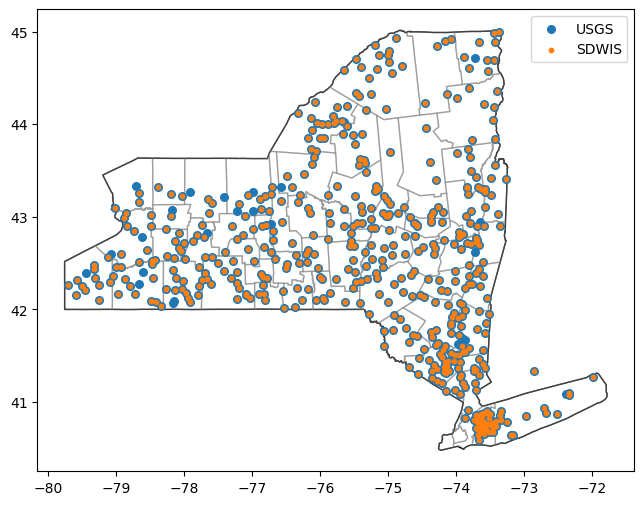

In [3]:
# Checking how many treatment facilities are in a county for the state NY
# Plot the state of MA

state_border = us_states.loc[us_states['STATEFP']=='36']
state_geo = us_counties.loc[us_counties['STATEFP']=='36']

fig, ax = plt.subplots(figsize = (14,6))
state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

# Get dataset for the state
dpc_2020_no_duplicates = dpc_2020.drop_duplicates('wsa_agidf')
dpc_2020_no_duplicates_state = dpc_2020_no_duplicates.loc[dpc_2020_no_duplicates['wsa_agidf'].str[0:2]=='ny']
# dpc_2020_no_duplicates_state.head(5)
wt_baseline_state = wt_baseline.loc[wt_baseline['PWS ID'].str[0:2]=='NY']
# wt_baseline_state.head(5)

# Plot the facilities in MA listed in the USGS dataset
ax.scatter(dpc_2020_no_duplicates_state['lon'],dpc_2020_no_duplicates_state['lat'],label = 'USGS',s = 30)

# Plot the facilities in MA listed in the filtered SDWIS dataset
ax.scatter(wt_baseline_state['Longitude'],wt_baseline_state['Latitude'],label='SDWIS',s=10)

ax.legend()